In [558]:
import numpy as np
import matplotlib.pyplot as plt
# import elasticnet as en
from sklearn.linear_model import ElasticNet
# import centering
from sklearn.preprocessing import StandardScaler


In [592]:
##################################
# From https://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/
def censored_lstsq(A, B, M):
    """Least squares of M * (AX - B) over X, where M is a masking matrix.
    """
    rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:])
    return np.linalg.solve(T, rhs).reshape(A.shape[1], B.shape[1])

def cv_pca(data, rank, p_holdout=.1):
    """Fit PCA while holding out a fraction of the dataset.
    """
    # create masking matrix
    M = np.random.rand(data.shape) < p_holdout

    # fit pca
    U = np.random.randn(data.shape[0], rank)
    for itr in range(20):
        Vt = censored_lstsq(U, data, M)
        U = censored_lstsq(Vt.T, data.T, M.T).T

    # We could orthogonalize U and Vt and then rotate to align
    # with directions of maximal variance, but we won't bother.

    # return result and test/train error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
    return train_err, test_err

##################################

def base_pca(X, n_components=None):
    """
    Principal component analysis (PCA)

    Parameters
    ----------
    X : array_like, shape (n_samples, n_features)
        Training data.
    n_components : int, optional (default=None)
        Number of components to keep.

    Returns
    -------
    X_pca : ndarray, shape (n_samples, n_components)
        Transformed data.
    """
    X = StandardScaler(with_mean=True, with_std=False, copy=True).fit_transform(X)
    N, D = X.shape
    if n_components is None:
        n_components = D
    C = np.cov(X.T)
    eigvals, eigvecs = np.linalg.eig(C)
    ind = np.argsort(eigvals)[::-1]
    eigvals = eigvals[ind][:n_components]
    eigvecs = eigvecs[:, ind][:, :n_components]
    X_pca = X @ eigvecs
    return X_pca, eigvals, eigvecs

def irls(X, y, max_iter=100, tol=1e-3, p=1):
    """
    Iteratively reweighted least squares (IRLS) algorithm for robust regression
    with Lp norm loss function.

    Parameters
    ----------
    X : array_like, shape (n_samples, n_features)
        Training data.
    y : array_like, shape (n_samples,)
        Target values.
    max_iter : int, optional (default=100)
        Maximum number of iterations.
    tol : float, optional (default=1e-3)
        Tolerance for stopping criteria.
    p : float, optional (default=1)
        Lp norm to be used for loss function.

    Returns
    -------
    w : ndarray, shape (n_features,)
        Weight vector.
    """
    X = StandardScaler(with_mean=True, with_std=False, copy=True).fit_transform(X)
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    for i in range(max_iter):
        w_old = w.copy()
        z = X.dot(w_old)
        r = y - z
        if i == 0:
            W = np.eye(n_samples)
        else:
            W = np.diag(np.abs(r + 1e-8)**(p-2))
        w = np.linalg.inv(X.T@W@X)@X.T@W@y

        if np.linalg.norm(w - w_old) < tol:
            break
    return w


def alternating_rpca(X, n_components, n_iter=100, alpha=0, l1_ratio=0.5):
    """
    Alternating Robust PCA

    Parameters
    ----------
    X : array_like, shape (n_samples, n_features)
        Training data.
    alpha : float, optional (default=0)
        Regularization parameter.

    """
    #loss = lambda X, A, B: np.linalg.norm(X@A - X@B, ord='fro')**2 + alpha*((1-l1_ratio)*np.linalg.norm(B, ord=2) + l1_ratio*np.linalg.norm(A, ord=2)
    N, D = X.shape
    C = np.cov(X.T)
    eigvals, eigvecs = np.linalg.eig(C)
    ind = np.argsort(eigvals)[::-1]
    eigvals = eigvals[ind][:n_components]
    eigvecs = eigvecs[:, ind][:, :n_components]
    
    A = eigvecs
    B = np.zeros((D, n_components))
    x_star = np.sqrt(N*C)
    
    for i in range(n_iter):
        y_star = x_star @ A
        for j in range(n_components):
            B[:, j] = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(x_star, y_star[:,j]).coef_
        U, S, Vt = np.linalg.svd(X.T@X@B, full_matrices=True)
        A = U@Vt
        
    return A, B


def bootstrap_pca(X, p=1, replace=True, n_components=None, n_iter=1000):
    assert p > 0, 'p must be positive'
    assert p <= 1 or (p > 1 and replace), 'p must be less than or equal to 1 if replace is False'
    
    if n_components is None:
        n_components = X.shape[1]
    
    X = StandardScaler(with_mean=True, with_std=False, copy=True).fit_transform(X)
    N, D = X.shape
    n = int(N*p)
    
    _,__,pcs = base_pca(X, n_components=n_components)
    for i in range(n_iter):
        ind = np.random.choice(N, n, replace=replace)
        _, __, pcs_new= base_pca(X[ind,:], n_components=n_components)
        # rotate pcs_new to match pcs
        for j in range(n_components):
            pcs_new[:,j] = pcs_new[:,j] * np.sign(pcs[:,j].T@pcs_new[:,j])
        if i == 0:
            pcs = pcs_new
        else:
            pcs += pcs_new
    
    # normalize pcs
    pcs = np.sqrt(np.linalg.inv(pcs@pcs.T))@pcs
    return X @ pcs, pcs



In [560]:
# generate example 2d data for pca. Data comes from 2 variate normal distribution
# with zero mean and covariance matrix [[1, 0.8], [0.8, 1]]
np.random.seed(1)
n = 100
mean = [0, 0]
rho = 0.7
var1 = 1.5
var2 = 0.3
cov = np.array([[var1, rho * np.sqrt(var1 * var2)], [rho * np.sqrt(var1 * var2), var2]])
data = np.random.multivariate_normal(mean, cov, n)

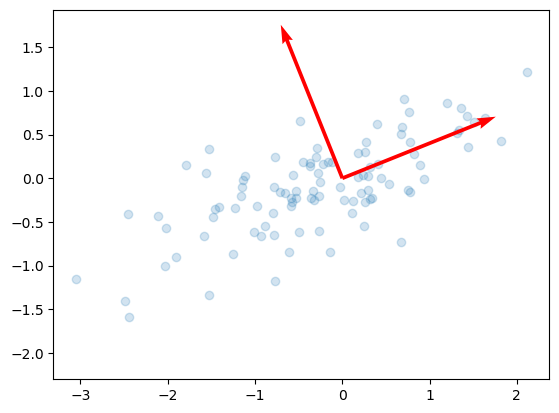

In [561]:
X = data - np.mean(data, axis=0, keepdims=True)
C = np.cov(X.T)
eigvals, eigvecs = np.linalg.eig(C)
plt.scatter(data[:, 0], data[:, 1], alpha=0.2)
plt.quiver([0],[0], eigvecs[0, 1], eigvecs[1,1], color=['r', 'b'], scale=3)
plt.quiver([0],[0], eigvecs[0, 0], eigvecs[1,0], color=['r', 'b'], scale=3)
plt.axis('equal')
plt.show()

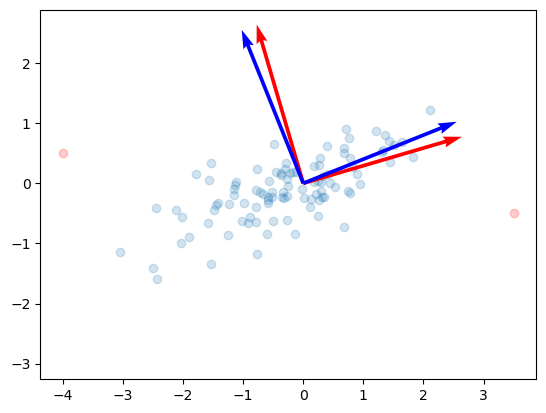

In [562]:
# add outliers to the data
outliers = np.array([[3.5, -.5], [-4, 0.5]])
corrupted_data = np.concatenate([data, outliers])
X_corrupted = corrupted_data - np.mean(corrupted_data, axis=0, keepdims=True)
C_corrupted = np.cov(X_corrupted.T)
eigvals_corrupted, eigvecs_corrupted = np.linalg.eig(C_corrupted)
plt.scatter(corrupted_data[:-2, 0], corrupted_data[:-2, 1], alpha=0.2)
plt.scatter(corrupted_data[-2:, 0], corrupted_data[-2:, 1], alpha=0.2, color='r')
plt.quiver([0],[0], eigvecs_corrupted[0, 1], eigvecs_corrupted[1,1], color=['r'], scale=3)
plt.quiver([0],[0], eigvecs_corrupted[0, 0], eigvecs_corrupted[1,0], color=['r'], scale=3)
plt.quiver([0],[0], eigvecs[0, 1], eigvecs[1,1], color=['b'], scale=3)
plt.quiver([0],[0], eigvecs[0, 0], eigvecs[1,0], color=['b'], scale=3)
plt.axis('equal')
plt.show()

In [593]:
#pca = X_corrupted @ eigvecs_corrupted[:, :2]
#A, B = alternating_rpca(X_corrupted, alpha=0.9, l1_ratio=0.9, n_iter=1000, n_components=2)
B = noised_rpca(X_corrupted, n_iter=1000, n_components=2)
pca = X_corrupted @ A
#_, A = bootstrap_pca(X_corrupted, n_iter=1000, replace=False, p=.5, n_components=2)

ValueError: shapes (2,102) and (2,2) not aligned: 102 (dim 1) != 2 (dim 0)

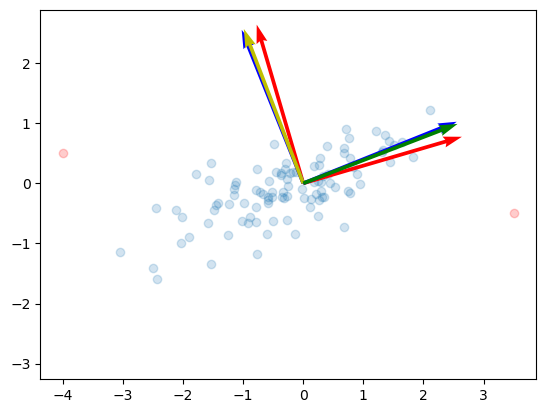

In [578]:
# rotate A to match eigvecs
for j in range(2):
    A[:,j] = A[:,j] * np.sign(eigvecs[:,j].T@A[:,j])
# plot quiver plot of the beta vectors
plt.scatter(corrupted_data[:-2, 0], corrupted_data[:-2, 1], alpha=0.2)
plt.scatter(corrupted_data[-2:, 0], corrupted_data[-2:, 1], alpha=0.2, color='r')
plt.quiver([0],[0], eigvecs_corrupted[0, 1], eigvecs_corrupted[1,1], color=['r'], scale=3)
plt.quiver([0],[0], eigvecs_corrupted[0, 0], eigvecs_corrupted[1,0], color=['r'], scale=3)
plt.quiver([0],[0], eigvecs[0, 1], eigvecs[1,1], color=['b'], scale=3)
plt.quiver([0],[0], eigvecs[0, 0], eigvecs[1,0], color=['b'], scale=3)
plt.quiver([0],[0], A[0,1], A[1,1], color=['y'], scale=3)
plt.quiver([0],[0], A[0,0], A[1,0], color=['g'], scale=3)
plt.axis('equal')
plt.show()

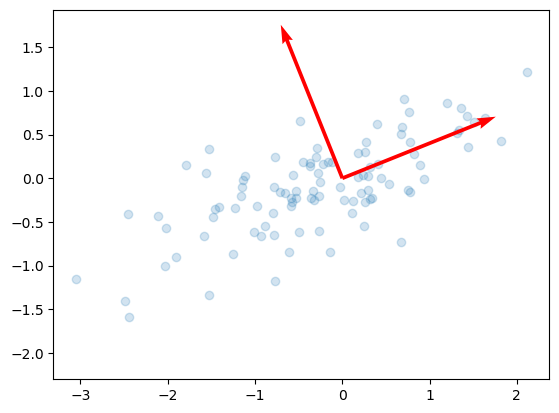

In [157]:
# plot quiver plot of the eigenvectors of the covariance matrix
X = data - np.mean(data, axis=0, keepdims=True)
C = np.cov(X.T)
eigvals, eigvecs = np.linalg.eig(C)
plt.scatter(data[:, 0], data[:, 1], alpha=0.2)
plt.quiver([0],[0], eigvecs[0, 1], eigvecs[1,1], color=['r', 'b'], scale=3)
plt.quiver([0],[0], eigvecs[0, 0], eigvecs[1,0], color=['r', 'b'], scale=3)
plt.axis('equal')
plt.show()